In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import genetools
from covid_serology import config, helpers
from numpy.testing import assert_array_equal

# Load data

In [2]:
# patients have multiple timepoints
infection_df = pd.read_csv(f"{config.paths.data_dir}/infection_cohort2.p11.csv")
infection_df

,sample_id,timepoint,days_post_pcr,Epsilon_ECL,Epsilon_AU,Beta_ECL,Beta_AU,Iota_ECL,Iota_AU,Gamma_ECL,...,Alpha_ECL,Alpha_AU,P.3_ECL,P.3_AU,Kappa_ECL,Kappa_AU,Delta_ECL,Delta_AU,Wuhan_ECL,Wuhan_AU
0,cohort2-0018,4,228,19783,5967.057398,8514,2405.272113,13499,3828.421082,11727,...,19816,5797.222285,9425,2410.448951,16563,5278.229108,18624,4178.190750,27363,7762.015799
1,cohort2-0019,3,85,4798,1426.718631,636,147.405969,2181,573.063270,1130,...,6828,1923.321929,1200,280.992017,3158,960.837008,4119,904.022488,8136,2276.722271
2,cohort2-0024,3,90,4837,1438.527943,1216,308.260083,2198,577.824282,1935,...,4312,1191.050365,1582,378.612703,3040,923.367841,4481,985.520810,5960,1658.812624
3,cohort2-0024,4,237,3231,952.290403,1381,354.399530,2099,550.110576,1890,...,2863,774.727250,1506,359.169935,2635,794.919849,3093,673.157477,3872,1067.045000
4,cohort2-0026,2,34,39413,11918.954990,7394,2079.039876,16450,4691.618502,14483,...,31578,9376.673944,9355,2392.175105,24663,7915.483514,40186,9059.919203,56104,16000.557400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,cohort2-OHC003,3,79,5181,1637.732421,1544,450.932599,3045,855.748859,2761,...,4916,1422.875424,1566,416.377925,4624,1482.124049,5083,1250.884315,6910,2127.507713
83,cohort2-OHC007,3,85,20067,6371.572784,3031,904.262248,9025,2595.740314,6109,...,15170,4449.862563,3454,945.262405,14352,4663.627440,19561,4908.494073,22856,7098.656767
84,cohort2-OHC007,4,219,7962,2524.604903,2197,650.324289,4645,1320.576512,3428,...,6781,1973.025246,2424,656.718277,6423,2070.360022,7850,1947.644719,9456,2921.096605
85,cohort2-OHC010,3,97,527,146.531403,380,93.163005,424,96.946363,444,...,611,154.586647,388,86.448679,423,108.999188,499,102.919142,527,138.418982


In [3]:
infection_participants = pd.read_csv(
    f"{config.paths.data_dir}/infection_cohort2.demographics.csv"
)
infection_participants

,Record.ID,Status
0,cohort2-0018,Mild
1,cohort2-0019,Mild
2,cohort2-0024,Mild
3,cohort2-0026,Mild
4,cohort2-0029,Mild
...,...,...
69,cohort2-0222,Mild
70,cohort2-OHC001,Mild
71,cohort2-OHC003,Mild
72,cohort2-OHC007,Mild


In [4]:
# one row per patient in demographics table
assert all(infection_participants["Record.ID"].value_counts() == 1)

In [5]:
infection_participants.columns

Index(['Record.ID', 'Status'], dtype='object')

# infection data reshape

In [6]:
infection_df.columns

Index(['sample_id', 'timepoint', 'days_post_pcr', 'Epsilon_ECL', 'Epsilon_AU',
       'Beta_ECL', 'Beta_AU', 'Iota_ECL', 'Iota_AU', 'Gamma_ECL', 'Gamma_AU',
       'B.1.526.2_ECL', 'B.1.526.2_AU', 'Alpha_ECL', 'Alpha_AU', 'P.3_ECL',
       'P.3_AU', 'Kappa_ECL', 'Kappa_AU', 'Delta_ECL', 'Delta_AU', 'Wuhan_ECL',
       'Wuhan_AU'],
      dtype='object')

In [7]:
# only one sample per patient per timepoint
assert all(infection_df.groupby(["sample_id", "timepoint"]).size() == 1)

In [8]:
# how many total samples per patient? many have only a single sample:
infection_df["sample_id"].value_counts().value_counts()

1    62
2    11
3     1
Name: sample_id, dtype: int64

In [9]:
infection_df = pd.melt(
    infection_df,
    id_vars=["sample_id", "timepoint", "days_post_pcr"],
    var_name="measurement",
)
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value
0,cohort2-0018,4,228,Epsilon_ECL,19783.000000
1,cohort2-0019,3,85,Epsilon_ECL,4798.000000
2,cohort2-0024,3,90,Epsilon_ECL,4837.000000
3,cohort2-0024,4,237,Epsilon_ECL,3231.000000
4,cohort2-0026,2,34,Epsilon_ECL,39413.000000
...,...,...,...,...,...
1735,cohort2-OHC003,3,79,Wuhan_AU,2127.507713
1736,cohort2-OHC007,3,85,Wuhan_AU,7098.656767
1737,cohort2-OHC007,4,219,Wuhan_AU,2921.096605
1738,cohort2-OHC010,3,97,Wuhan_AU,138.418982


In [10]:
# just in case, convert to float and switch non-numeric values to nan
infection_df["value"] = pd.to_numeric(infection_df["value"], errors="coerce")
infection_df.dtypes

sample_id         object
timepoint          int64
days_post_pcr      int64
measurement       object
value            float64
dtype: object

In [11]:
infection_df["value"].isna().value_counts()

False    1740
Name: value, dtype: int64

In [12]:
infection_df[infection_df["value"].isna()]

,sample_id,timepoint,days_post_pcr,measurement,value


In [13]:
measurement_cols = infection_df["measurement"]
measurement_cols = measurement_cols[measurement_cols.str.contains("AU")].unique()
helpers.confirm_all_measurement_columns_are_present(measurement_cols)
measurement_cols

array(['Epsilon_AU', 'Beta_AU', 'Iota_AU', 'Gamma_AU', 'B.1.526.2_AU',
       'Alpha_AU', 'P.3_AU', 'Kappa_AU', 'Delta_AU', 'Wuhan_AU'],
      dtype=object)

In [14]:
infection_df = infection_df[infection_df["measurement"].isin(measurement_cols)].copy()
infection_df["measurement"].value_counts()

Epsilon_AU      87
Iota_AU         87
Alpha_AU        87
B.1.526.2_AU    87
P.3_AU          87
Delta_AU        87
Wuhan_AU        87
Beta_AU         87
Gamma_AU        87
Kappa_AU        87
Name: measurement, dtype: int64

In [15]:
infection_df["measurement"] = infection_df["measurement"].str.replace("_AU", "")
infection_df["measurement"].value_counts()

Iota         87
P.3          87
Wuhan        87
B.1.526.2    87
Kappa        87
Alpha        87
Beta         87
Delta        87
Gamma        87
Epsilon      87
Name: measurement, dtype: int64

In [16]:
# extract parts of measurement column
# all variant plate measurements are IgG only
measurement_parts = (
    infection_df["measurement"]
    .rename("virus")
    .to_frame()
    .assign(variant_plate_type="Variant", target="RBD", antibody="IgG")
    .apply(lambda col: col.str.strip())
)
measurement_parts

,virus,variant_plate_type,target,antibody
87,Epsilon,Variant,RBD,IgG
88,Epsilon,Variant,RBD,IgG
89,Epsilon,Variant,RBD,IgG
90,Epsilon,Variant,RBD,IgG
91,Epsilon,Variant,RBD,IgG
...,...,...,...,...
1735,Wuhan,Variant,RBD,IgG
1736,Wuhan,Variant,RBD,IgG
1737,Wuhan,Variant,RBD,IgG
1738,Wuhan,Variant,RBD,IgG


In [17]:
measurement_parts["virus"].value_counts()

Iota         87
P.3          87
Wuhan        87
B.1.526.2    87
Kappa        87
Alpha        87
Beta         87
Delta        87
Gamma        87
Epsilon      87
Name: virus, dtype: int64

In [18]:
measurement_parts["target"].value_counts()

RBD    870
Name: target, dtype: int64

In [19]:
measurement_parts["antibody"].value_counts()

IgG    870
Name: antibody, dtype: int64

In [20]:
measurement_parts["variant_plate_type"].value_counts()

Variant    870
Name: variant_plate_type, dtype: int64

In [21]:
infection_df = pd.concat([infection_df, measurement_parts], axis=1)
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value,virus,variant_plate_type,target,antibody
87,cohort2-0018,4,228,Epsilon,5967.057398,Epsilon,Variant,RBD,IgG
88,cohort2-0019,3,85,Epsilon,1426.718631,Epsilon,Variant,RBD,IgG
89,cohort2-0024,3,90,Epsilon,1438.527943,Epsilon,Variant,RBD,IgG
90,cohort2-0024,4,237,Epsilon,952.290403,Epsilon,Variant,RBD,IgG
91,cohort2-0026,2,34,Epsilon,11918.954990,Epsilon,Variant,RBD,IgG
...,...,...,...,...,...,...,...,...,...
1735,cohort2-OHC003,3,79,Wuhan,2127.507713,Wuhan,Variant,RBD,IgG
1736,cohort2-OHC007,3,85,Wuhan,7098.656767,Wuhan,Variant,RBD,IgG
1737,cohort2-OHC007,4,219,Wuhan,2921.096605,Wuhan,Variant,RBD,IgG
1738,cohort2-OHC010,3,97,Wuhan,138.418982,Wuhan,Variant,RBD,IgG


<AxesSubplot:>

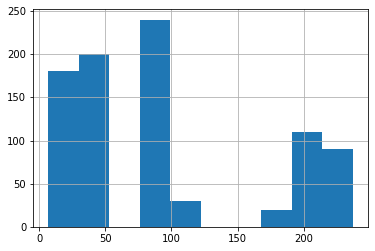

In [22]:
infection_df["days_post_pcr"].hist()

In [23]:
infection_df["timepoint"].value_counts()

3    270
2    230
4    220
1    150
Name: timepoint, dtype: int64

In [24]:
# timepoint label map
map_infection_to_global_timepoint_labels = {
    1: "day 21 / weeks 2&3",
    2: "day 28 / week 4",
    3: "week 7 and later / 3 months",
    4: "day 210 / 7 months",
}
assert all(
    tp in map_infection_to_global_timepoint_labels.keys()
    for tp in infection_df["timepoint"].unique()
)

In [25]:
infection_df

,sample_id,timepoint,days_post_pcr,measurement,value,virus,variant_plate_type,target,antibody
87,cohort2-0018,4,228,Epsilon,5967.057398,Epsilon,Variant,RBD,IgG
88,cohort2-0019,3,85,Epsilon,1426.718631,Epsilon,Variant,RBD,IgG
89,cohort2-0024,3,90,Epsilon,1438.527943,Epsilon,Variant,RBD,IgG
90,cohort2-0024,4,237,Epsilon,952.290403,Epsilon,Variant,RBD,IgG
91,cohort2-0026,2,34,Epsilon,11918.954990,Epsilon,Variant,RBD,IgG
...,...,...,...,...,...,...,...,...,...
1735,cohort2-OHC003,3,79,Wuhan,2127.507713,Wuhan,Variant,RBD,IgG
1736,cohort2-OHC007,3,85,Wuhan,7098.656767,Wuhan,Variant,RBD,IgG
1737,cohort2-OHC007,4,219,Wuhan,2921.096605,Wuhan,Variant,RBD,IgG
1738,cohort2-OHC010,3,97,Wuhan,138.418982,Wuhan,Variant,RBD,IgG


In [26]:
def process_infection_timepoint(df_partial, timepoint):
    # at a given time point: only one measurement per patient-virus-target combo
    assert all(
        df_partial.groupby(
            ["sample_id", "virus", "target", "variant_plate_type", "antibody"]
        ).size()
        == 1
    )

    # unmelt into matrix
    infection_df_pivot = pd.pivot(
        df_partial,
        index="sample_id",
        columns=[
            "virus",
            "target",
            "variant_plate_type",
            "antibody",
        ],
        values="value",
    )

    ## set column names
    variable_info = infection_df_pivot.columns.to_frame().reset_index(drop=True)
    # create combined name
    variable_info["timepoint"] = timepoint
    variable_info["combined_name"] = variable_info.apply("_".join, axis=1)
    variable_info = variable_info.set_index("combined_name")

    # set var names
    infection_df_pivot.columns = variable_info.index.copy()

    # drop patients with any NaNs in this timepoint
    infection_df_pivot = infection_df_pivot.dropna(how="any")
    assert not infection_df_pivot.isna().any().any()

    return infection_df_pivot, variable_info

In [27]:
X_partial = []
var_partial = []

for infection_timepoint in infection_df["timepoint"].unique():
    associated_global_timepoint_label = map_infection_to_global_timepoint_labels[
        infection_timepoint
    ]

    print(infection_timepoint, "->", associated_global_timepoint_label)

    df_partial = infection_df[infection_df["timepoint"] == infection_timepoint]
    infection_df_pivot, variable_info = process_infection_timepoint(
        df_partial, associated_global_timepoint_label
    )

    X_partial.append(infection_df_pivot)
    var_partial.append(variable_info)

infection_df_pivot = pd.concat(X_partial, axis=1)
variable_info = pd.concat(var_partial, axis=0)

4 -> day 210 / 7 months
3 -> week 7 and later / 3 months
2 -> day 28 / week 4
1 -> day 21 / weeks 2&3


In [28]:
# note: there are NaNs - patients don't have entries for all timepoints
infection_df_pivot

combined_name,Epsilon_RBD_Variant_IgG_day 210 / 7 months,Beta_RBD_Variant_IgG_day 210 / 7 months,Iota_RBD_Variant_IgG_day 210 / 7 months,Gamma_RBD_Variant_IgG_day 210 / 7 months,B.1.526.2_RBD_Variant_IgG_day 210 / 7 months,Alpha_RBD_Variant_IgG_day 210 / 7 months,P.3_RBD_Variant_IgG_day 210 / 7 months,Kappa_RBD_Variant_IgG_day 210 / 7 months,Delta_RBD_Variant_IgG_day 210 / 7 months,Wuhan_RBD_Variant_IgG_day 210 / 7 months,...,Epsilon_RBD_Variant_IgG_day 21 / weeks 2&3,Beta_RBD_Variant_IgG_day 21 / weeks 2&3,Iota_RBD_Variant_IgG_day 21 / weeks 2&3,Gamma_RBD_Variant_IgG_day 21 / weeks 2&3,B.1.526.2_RBD_Variant_IgG_day 21 / weeks 2&3,Alpha_RBD_Variant_IgG_day 21 / weeks 2&3,P.3_RBD_Variant_IgG_day 21 / weeks 2&3,Kappa_RBD_Variant_IgG_day 21 / weeks 2&3,Delta_RBD_Variant_IgG_day 21 / weeks 2&3,Wuhan_RBD_Variant_IgG_day 21 / weeks 2&3
sample_id,,,,,,,,,,,,,,,,,,,,,
cohort2-0018,5967.057398,2405.272113,3828.421082,3353.863254,6419.449115,5797.222285,2410.448951,5278.229108,4178.190750,7762.015799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0024,952.290403,354.399530,550.110576,504.686208,904.559172,774.727250,359.169935,794.919849,673.157477,1067.045000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0026,819.404580,281.759035,474.128547,400.524842,876.757401,689.510810,279.716130,678.437335,622.782088,948.194965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0029,3169.597092,541.790061,1965.719067,706.943622,2767.721376,2713.390241,1617.146643,2774.590356,2428.479456,3467.461961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cohort2-0033,549.141847,181.301267,310.566287,309.461230,583.142314,442.829916,226.180051,454.475957,391.088918,681.085613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cohort2-0095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2848.846191,851.944958,3350.401891,2173.489889,19789.370510,9650.487282,879.427584,2653.430983,2303.261447,21114.914650
cohort2-0098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3424.926047,578.025285,1224.648243,906.838973,3587.206858,2649.434220,585.566438,2460.811756,2474.874833,4366.595051
cohort2-0101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,272134.963400,56670.770600,130572.767900,131973.559000,216850.271400,172451.002900,67988.716710,234925.074000,200235.060800,264958.777600


In [29]:
variable_info

,virus,target,variant_plate_type,antibody,timepoint
combined_name,,,,,
Epsilon_RBD_Variant_IgG_day 210 / 7 months,Epsilon,RBD,Variant,IgG,day 210 / 7 months
Beta_RBD_Variant_IgG_day 210 / 7 months,Beta,RBD,Variant,IgG,day 210 / 7 months
Iota_RBD_Variant_IgG_day 210 / 7 months,Iota,RBD,Variant,IgG,day 210 / 7 months
Gamma_RBD_Variant_IgG_day 210 / 7 months,Gamma,RBD,Variant,IgG,day 210 / 7 months
B.1.526.2_RBD_Variant_IgG_day 210 / 7 months,B.1.526.2,RBD,Variant,IgG,day 210 / 7 months
Alpha_RBD_Variant_IgG_day 210 / 7 months,Alpha,RBD,Variant,IgG,day 210 / 7 months
P.3_RBD_Variant_IgG_day 210 / 7 months,P.3,RBD,Variant,IgG,day 210 / 7 months
Kappa_RBD_Variant_IgG_day 210 / 7 months,Kappa,RBD,Variant,IgG,day 210 / 7 months
Delta_RBD_Variant_IgG_day 210 / 7 months,Delta,RBD,Variant,IgG,day 210 / 7 months


In [30]:
infection_participants

,Record.ID,Status
0,cohort2-0018,Mild
1,cohort2-0019,Mild
2,cohort2-0024,Mild
3,cohort2-0026,Mild
4,cohort2-0029,Mild
...,...,...
69,cohort2-0222,Mild
70,cohort2-OHC001,Mild
71,cohort2-OHC003,Mild
72,cohort2-OHC007,Mild


In [31]:
# attach status
infection_participants = infection_participants.set_index("Record.ID")
# set index to str for anndata: anndata requires string indices
infection_participants.index = infection_participants.index.astype(str)

In [32]:
infection_participants["Status"].value_counts()

Mild            58
Critical         7
Moderate         6
Severe           2
Asymptomatic     1
Name: Status, dtype: int64

In [33]:
# reorder participants info to match
infection_participants = infection_participants.loc[infection_df_pivot.index]
infection_participants

,Status
sample_id,
cohort2-0018,Mild
cohort2-0024,Mild
cohort2-0026,Mild
cohort2-0029,Mild
cohort2-0033,Mild
...,...
cohort2-0095,Mild
cohort2-0098,Mild
cohort2-0101,Critical


In [34]:
infection_participants.columns

Index(['Status'], dtype='object')

In [35]:
adata_infection = anndata.AnnData(
    X=infection_df_pivot, obs=infection_participants, var=variable_info
)
adata_infection

AnnData object with n_obs × n_vars = 74 × 40
    obs: 'Status'
    var: 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint'

In [36]:
adata_infection.var

,virus,target,variant_plate_type,antibody,timepoint
combined_name,,,,,
Epsilon_RBD_Variant_IgG_day 210 / 7 months,Epsilon,RBD,Variant,IgG,day 210 / 7 months
Beta_RBD_Variant_IgG_day 210 / 7 months,Beta,RBD,Variant,IgG,day 210 / 7 months
Iota_RBD_Variant_IgG_day 210 / 7 months,Iota,RBD,Variant,IgG,day 210 / 7 months
Gamma_RBD_Variant_IgG_day 210 / 7 months,Gamma,RBD,Variant,IgG,day 210 / 7 months
B.1.526.2_RBD_Variant_IgG_day 210 / 7 months,B.1.526.2,RBD,Variant,IgG,day 210 / 7 months
Alpha_RBD_Variant_IgG_day 210 / 7 months,Alpha,RBD,Variant,IgG,day 210 / 7 months
P.3_RBD_Variant_IgG_day 210 / 7 months,P.3,RBD,Variant,IgG,day 210 / 7 months
Kappa_RBD_Variant_IgG_day 210 / 7 months,Kappa,RBD,Variant,IgG,day 210 / 7 months
Delta_RBD_Variant_IgG_day 210 / 7 months,Delta,RBD,Variant,IgG,day 210 / 7 months


In [37]:
adata_infection.obs["Status"].value_counts()

Mild            58
Critical         7
Moderate         6
Severe           2
Asymptomatic     1
Name: Status, dtype: int64

In [38]:
adata_infection.write(
    f"{config.paths.generated_data_dir}/partial.infection_cohort2.variant_plate.h5"
)

... storing 'Status' as categorical


... storing 'virus' as categorical


... storing 'target' as categorical


... storing 'variant_plate_type' as categorical


... storing 'antibody' as categorical


... storing 'timepoint' as categorical


In [39]:
# confirm multiple timepoints are kept for a patients with multiple timepoint
adata_infection.to_df().loc[infection_df["sample_id"].value_counts().idxmax()]

combined_name
Epsilon_RBD_Variant_IgG_day 210 / 7 months                 819.404602
Beta_RBD_Variant_IgG_day 210 / 7 months                    281.759033
Iota_RBD_Variant_IgG_day 210 / 7 months                    474.128540
Gamma_RBD_Variant_IgG_day 210 / 7 months                   400.524841
B.1.526.2_RBD_Variant_IgG_day 210 / 7 months               876.757385
Alpha_RBD_Variant_IgG_day 210 / 7 months                   689.510803
P.3_RBD_Variant_IgG_day 210 / 7 months                     279.716125
Kappa_RBD_Variant_IgG_day 210 / 7 months                   678.437317
Delta_RBD_Variant_IgG_day 210 / 7 months                   622.782104
Wuhan_RBD_Variant_IgG_day 210 / 7 months                   948.194946
Epsilon_RBD_Variant_IgG_week 7 and later / 3 months       3642.562988
Beta_RBD_Variant_IgG_week 7 and later / 3 months           946.146423
Iota_RBD_Variant_IgG_week 7 and later / 3 months          1776.084839
Gamma_RBD_Variant_IgG_week 7 and later / 3 months         1548.585327
B.1.52